# Package Releases Lookahead Metrics

## Setup

In [1]:
import re
from pathlib import Path

import seaborn as sns
import opinionated  # noqa
import colormaps as cmaps
import matplotlib.pyplot as plt
import polars as pl

plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# Data dir
data_dir = (
    Path("~/active/dg-uoi-analysis/data/per-day-pkg-releases-metrics")
    .expanduser()
    .resolve()
    .absolute()
)

# Lazy read parquet files (all files in dir via glob)
lazy_frame = pl.scan_parquet(source=data_dir / "*")

# Lowercase all column names
lazy_frame = lazy_frame.select(pl.all().reverse().name.to_lowercase())

# Tame a random sample
lazy_frame.head(5).collect()

repo_created_date,package_managers,package_version,package_major_version,package_minor_version,package_patch_version,release_type,publish_datetime,publish_date,num_dependencies,num_stars_day_of_release,num_public_forks_day_of_release,num_dependents_on_release_date,num_dependents_plus_90_days,num_stars_plus_90_days,num_forks_plus_90_days,num_dependents_plus_180_days,num_stars_plus_180_days,num_forks_plus_180_days,num_dependents_plus_270_days,num_stars_plus_270_days,num_forks_plus_270_days,num_dependents_plus_360_days,num_stars_plus_360_days,num_forks_plus_360_days,normalized_package_manager,package_uuid
str,str,str,i64,i64,f64,str,datetime[ns],str,i64,i64,i64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,str,str
"""2018-05-31""","""rubygems""","""3.2.6""",3,2,6.0,"""patch""",2023-07-27 07:00:00,"""2023-07-27""",3,110,47,59567.0,59485,113.0,47.0,59493,114.0,50.0,59460,122.0,46.0,59388,134.0,57.0,"""rubygems""","""7521ddc9-bd2a-4efb-8038-d2154c…"
"""2014-06-15""","""npm""","""5.1.0""",5,1,0.0,"""minor""",2023-07-27 23:41:46,"""2023-07-27""",8,100,49,15.0,21,106.0,50.0,24,109.0,53.0,28,118.0,53.0,28,123.0,55.0,"""npm""","""24d548fd-cd39-472c-aac1-7fb4c0…"
"""2016-01-15""","""npm; rust""","""0.20.2""",0,20,2.0,"""zero-minor""",2023-07-27 10:22:56,"""2023-07-27""",7,182,57,43.0,43,202.0,64.0,47,220.0,67.0,51,239.0,73.0,48,256.0,79.0,"""multilingual""","""fae5aa93-6d98-41b6-b77b-0ef0ff…"
"""2017-01-01""","""rust""","""0.6.0""",0,6,0.0,"""zero-major""",2023-07-27 18:34:30,"""2023-07-27""",11,116,39,14.0,12,121.0,39.0,12,127.0,41.0,12,129.0,42.0,12,135.0,44.0,"""rust""","""0a273c11-9207-48a8-870a-605419…"
"""2019-03-02""","""rust""","""0.7.2""",0,7,2.0,"""zero-minor""",2023-07-27 01:47:49,"""2023-07-27""",12,104,13,13.0,13,108.0,13.0,14,111.0,15.0,14,114.0,15.0,14,118.0,18.0,"""rust""","""23dcc8e4-5893-4332-815b-fc0d9f…"


In [3]:
# Compute number of unique packages
num_unique_packages = len(lazy_frame.select("package_uuid").unique().collect())
print(f"Number of unique packages: {num_unique_packages}")

Number of unique packages: 21244


## Package Releases by Ecosystem

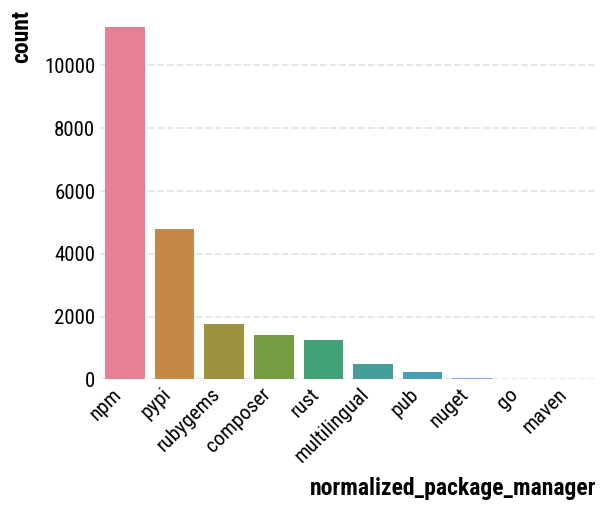

In [4]:
# Count plot of package manager
ecosystem_counts = (
    lazy_frame.unique(subset="package_uuid", keep="first")
    .select(pl.col("normalized_package_manager").value_counts(sort=True))
    .collect()
    .unnest("normalized_package_manager")
)

_ = sns.barplot(
    data=ecosystem_counts,
    x="normalized_package_manager",
    y="count",
    hue="normalized_package_manager",
)
_ = plt.xticks(rotation=45, ha="right")

## Package Releases by Release Type

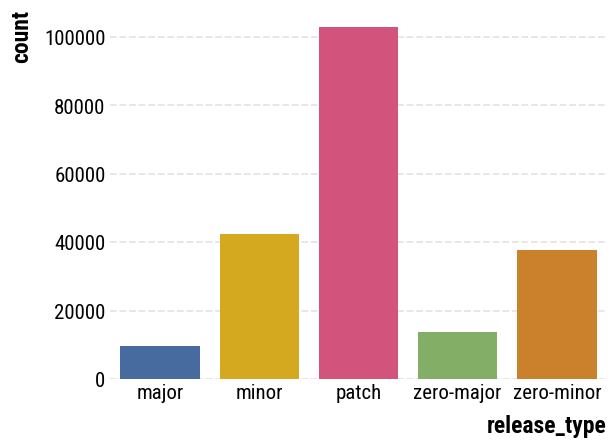

In [5]:
release_type_counts = (
    lazy_frame.filter(pl.col("release_type") != "unknown")
    .select(pl.col("release_type").value_counts())
    .unnest("release_type")
    .sort(by="release_type")
    .collect()
)

# Plot count of release types
_ = sns.barplot(
    data=release_type_counts,
    x="release_type",
    y="count",
    hue="release_type",
)

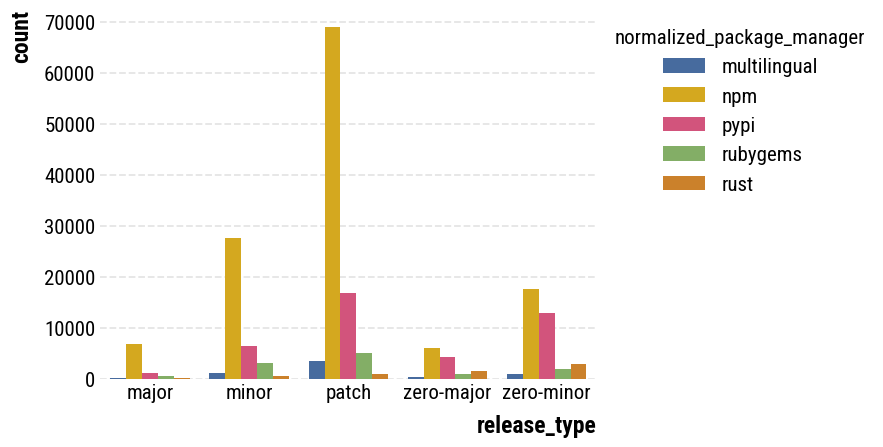

In [6]:
ecosystem_releases_counts = (
    lazy_frame.select(pl.col(["normalized_package_manager", "release_type"]))
    .filter(
        pl.col("normalized_package_manager").is_in(
            ["npm", "pypi", "multilingual", "rubygems", "rust"]
        )
    )
    .filter(pl.col("release_type") != "unknown")
    .group_by(pl.all())
    .len(name="count")
    .sort(by=["normalized_package_manager", "release_type"])
    .collect()
)

ax = sns.barplot(
    data=ecosystem_releases_counts,
    x="release_type",
    y="count",
    hue="normalized_package_manager",
)

# Move legend outside of plot
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Look Ahead Metrics

### Percent Growth in Stars by Package Ecosystem

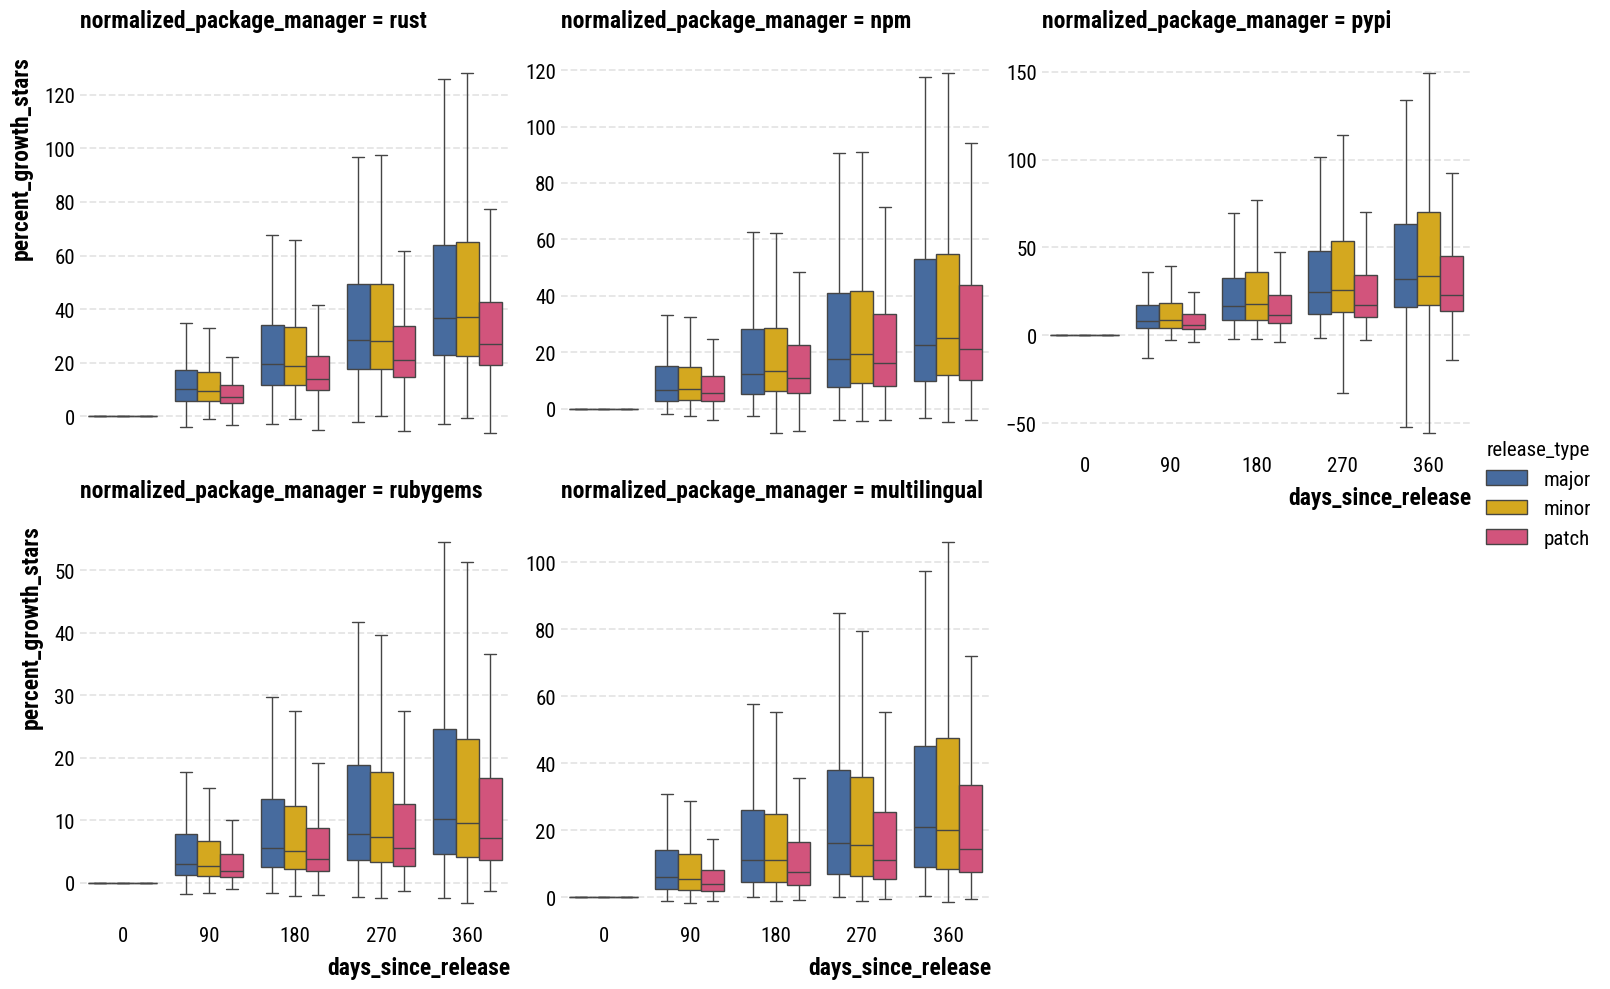

In [7]:
selected_columns = [
    col_name
    for col_name in lazy_frame.collect_schema().names()
    if "num_stars_" in col_name
]

# Calculate percent growth in stars
constructed_exprs = []
for col_name in selected_columns:
    # Handle the easy case (no extra timedelta addition)
    if col_name == "num_stars_day_of_release":
        constructed_exprs.append(
            (
                (
                    (pl.col(col_name) - pl.col("num_stars_day_of_release"))
                    / pl.col("num_stars_day_of_release")
                )
                * 100
            ).alias("percent_growth_stars_0_days")
        )

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                (
                    (pl.col(col_name) - pl.col("num_stars_day_of_release"))
                    / pl.col("num_stars_day_of_release")
                )
                * 100
            ).alias(f"percent_growth_stars_{timedelta_int}_days")
        )

# Create new column for log growth stars
pct_growth_stars_ecosystem_release_type = (
    lazy_frame.filter(
        pl.col("normalized_package_manager").is_in(
            ["npm", "pypi", "multilingual", "rubygems", "rust"]
        )
    )
    .filter(pl.col("release_type") != "unknown")
    .select(
        pl.col("package_major_version"),
        pl.col("normalized_package_manager"),
        pl.col("release_type")
        .str.replace("zero-major", "major")
        .str.replace("zero-minor", "minor")
        .alias("release_type"),
        *constructed_exprs,
    )
    .unpivot(
        index=["normalized_package_manager", "release_type", "package_major_version"],
        variable_name="days_since_release",
        value_name="percent_growth_stars",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(r"^(percent_growth_stars_)(\d+)(_days)$", r"$2")
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
    .collect()
)

# Plot pct growth dependents
_ = sns.catplot(
    data=pct_growth_stars_ecosystem_release_type,
    x="days_since_release",
    y="percent_growth_stars",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    col="normalized_package_manager",
    col_wrap=3,
    showfliers=False,
    sharey=False,
)

### Percent Growth in Dependents by Package Ecosystem

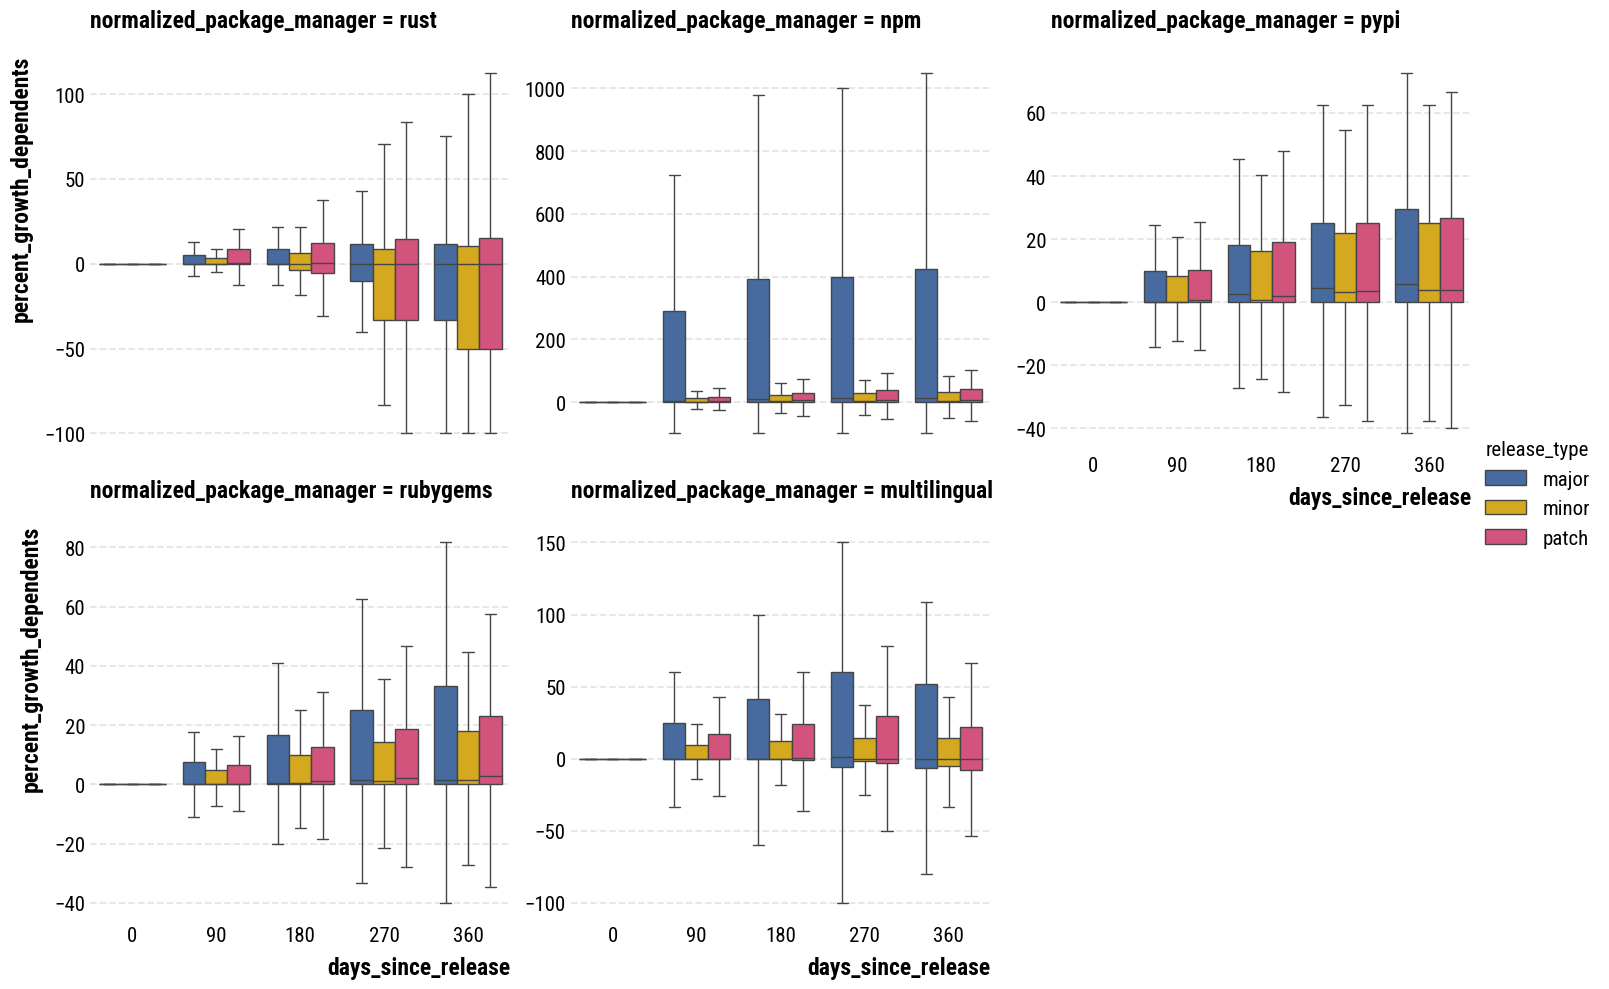

In [8]:
selected_columns = [
    col_name
    for col_name in lazy_frame.collect_schema().names()
    if "num_dependents_" in col_name
]

# Calculate percent growth in dependents
constructed_exprs = []
for col_name in selected_columns:
    # Handle the easy case (no extra timedelta addition)
    if col_name == "num_dependents_on_release_date":
        constructed_exprs.append(
            (
                (
                    (pl.col(col_name) - pl.col("num_dependents_on_release_date"))
                    / pl.col("num_dependents_on_release_date")
                )
                * 100
            ).alias("percent_growth_dependents_0_days")
        )

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                (
                    (pl.col(col_name) - pl.col("num_dependents_on_release_date"))
                    / pl.col("num_dependents_on_release_date")
                )
                * 100
            ).alias(f"percent_growth_dependents_{timedelta_int}_days")
        )

# Create new column for log growth stars
pct_growth_dependents_ecosystem_release_type = (
    lazy_frame.filter(
        pl.col("normalized_package_manager").is_in(
            ["npm", "pypi", "multilingual", "rubygems", "rust"]
        )
    )
    .filter(pl.col("release_type") != "unknown")
    .select(
        pl.col("package_major_version"),
        pl.col("normalized_package_manager"),
        pl.col("release_type")
        .str.replace("zero-major", "major")
        .str.replace("zero-minor", "minor")
        .alias("release_type"),
        *constructed_exprs,
    )
    .unpivot(
        index=["normalized_package_manager", "release_type", "package_major_version"],
        variable_name="days_since_release",
        value_name="percent_growth_dependents",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(r"^(percent_growth_dependents_)(\d+)(_days)$", r"$2")
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
    .collect()
)

# Plot pct growth dependents
_ = sns.catplot(
    data=pct_growth_dependents_ecosystem_release_type,
    x="days_since_release",
    y="percent_growth_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    col="normalized_package_manager",
    col_wrap=3,
    showfliers=False,
    sharey=False,
)

#### Percent Growth in Dependents by Package Ecosystem (Subset to Zero-Ver)

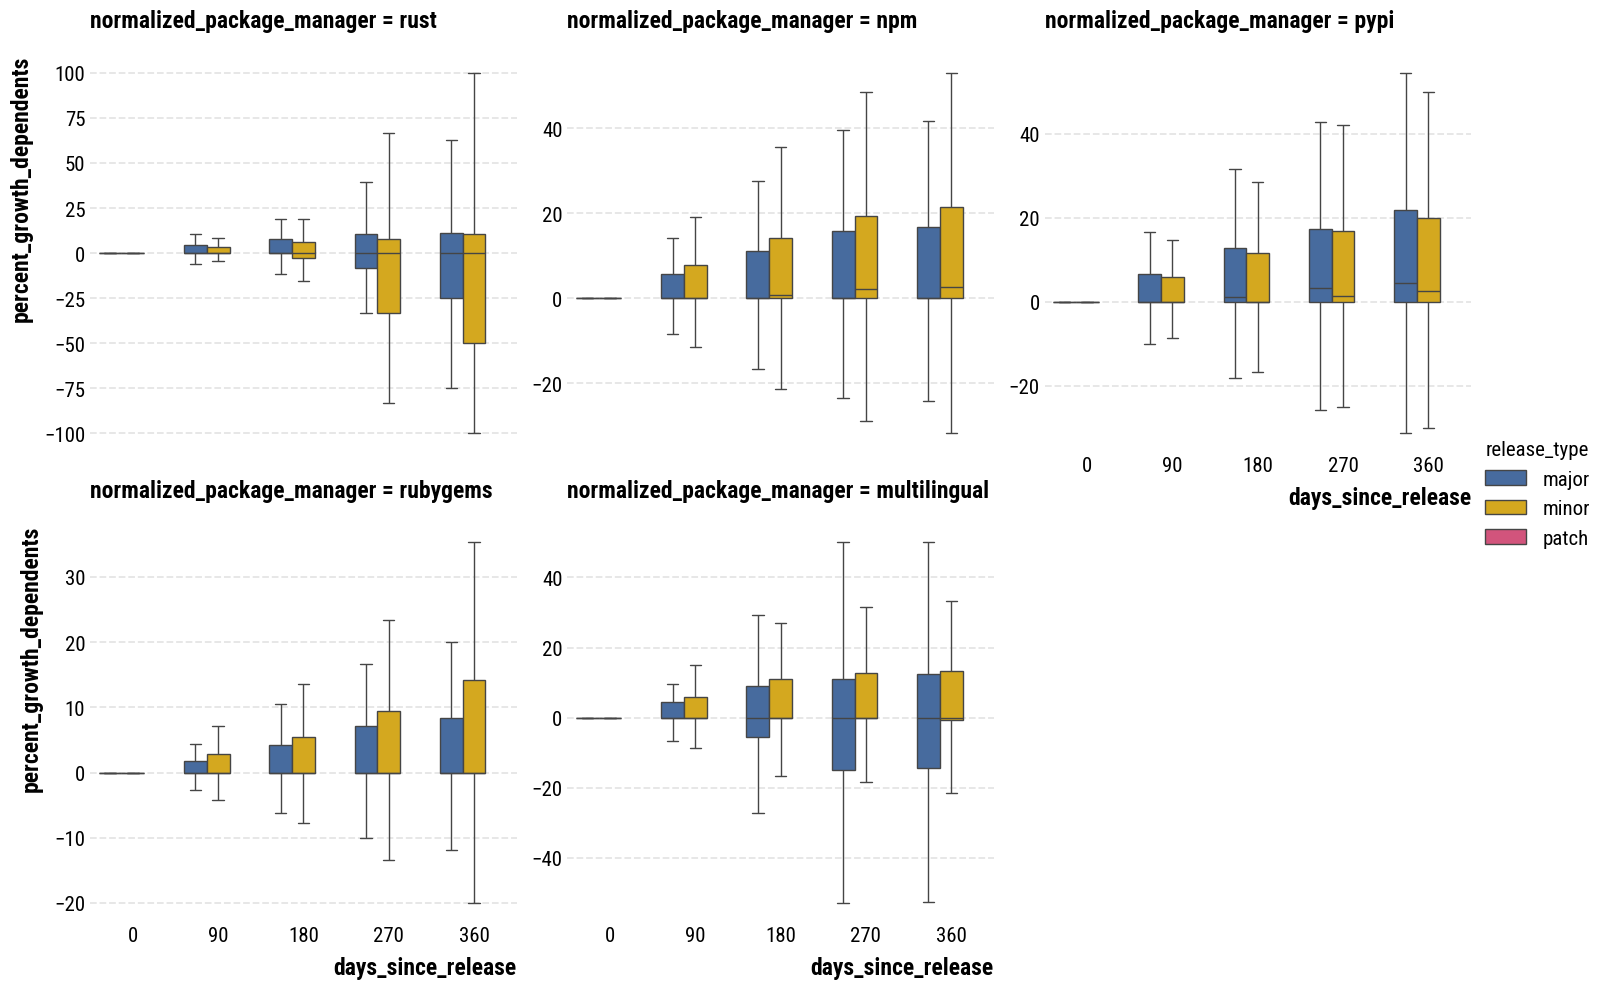

In [9]:
# Plot pct growth dependents
_ = sns.catplot(
    data=pct_growth_dependents_ecosystem_release_type.filter(
        pl.col("package_major_version").eq(pl.lit(0)),
    ),
    x="days_since_release",
    y="percent_growth_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    col="normalized_package_manager",
    col_wrap=3,
    showfliers=False,
    sharey=False,
)

#### Percent Growth in Dependents by Package Ecosystem (Subset to One-Ver)

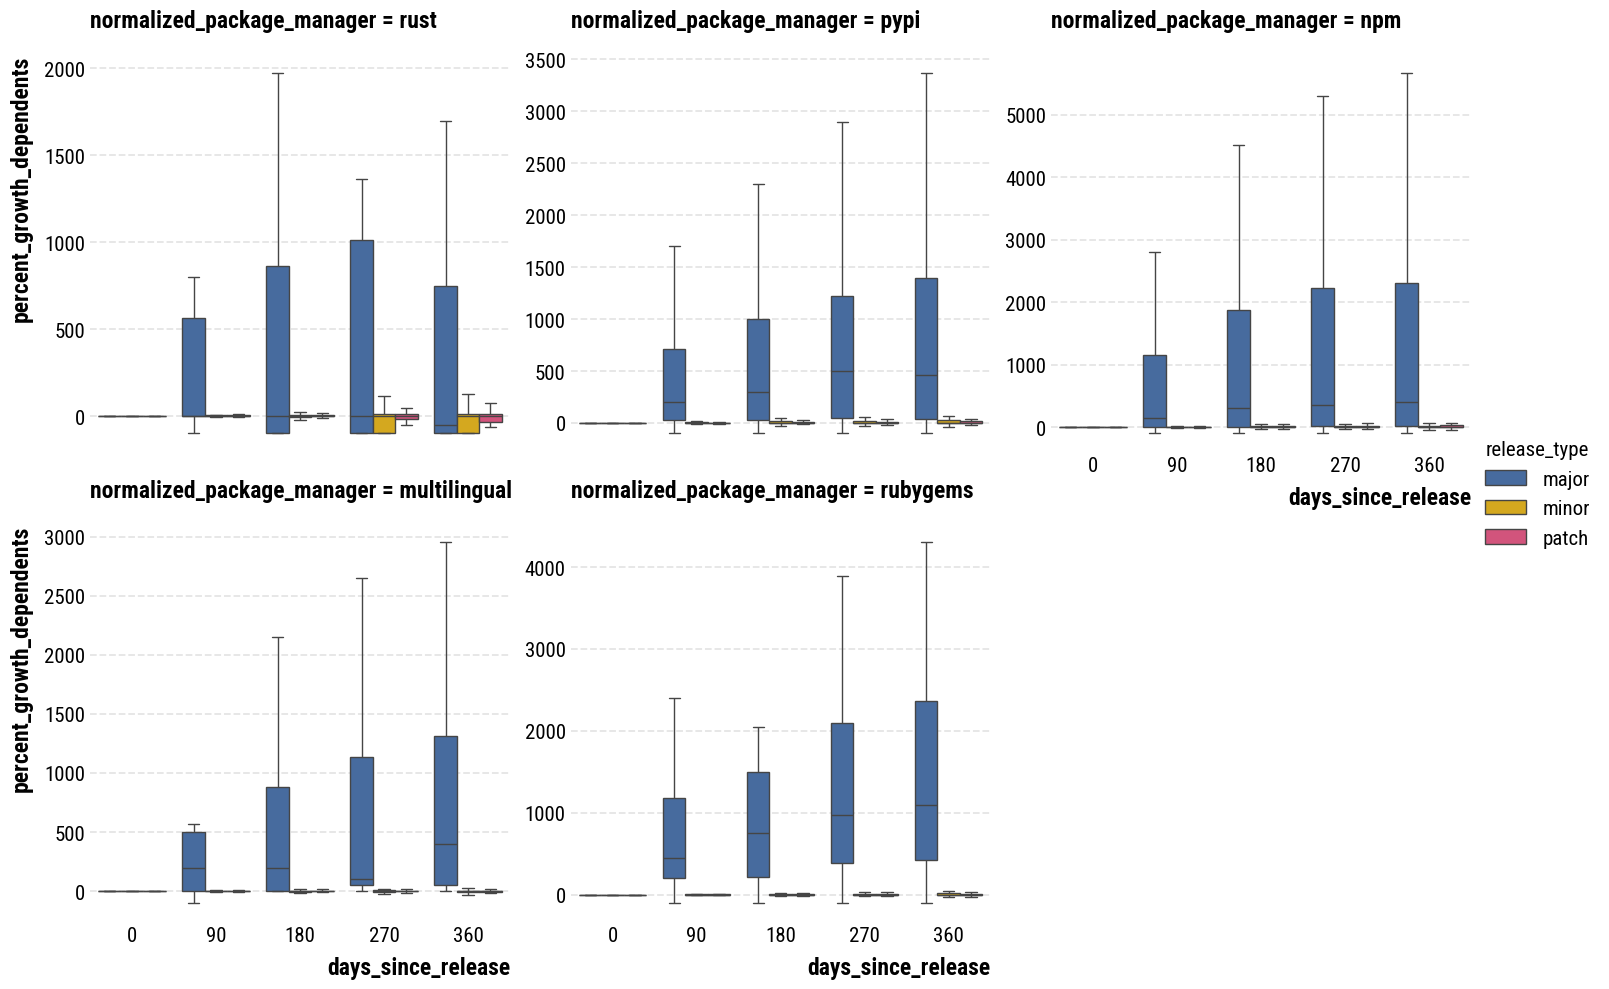

In [10]:
# Plot pct growth dependents
_ = sns.catplot(
    data=pct_growth_dependents_ecosystem_release_type.filter(
        pl.col("package_major_version").eq(pl.lit(1)),
    ),
    x="days_since_release",
    y="percent_growth_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    col="normalized_package_manager",
    col_wrap=3,
    showfliers=False,
    sharey=False,
)

#### Percent Growth in Dependents by Package Ecosystem (Subset to Two-Plus-Ver)

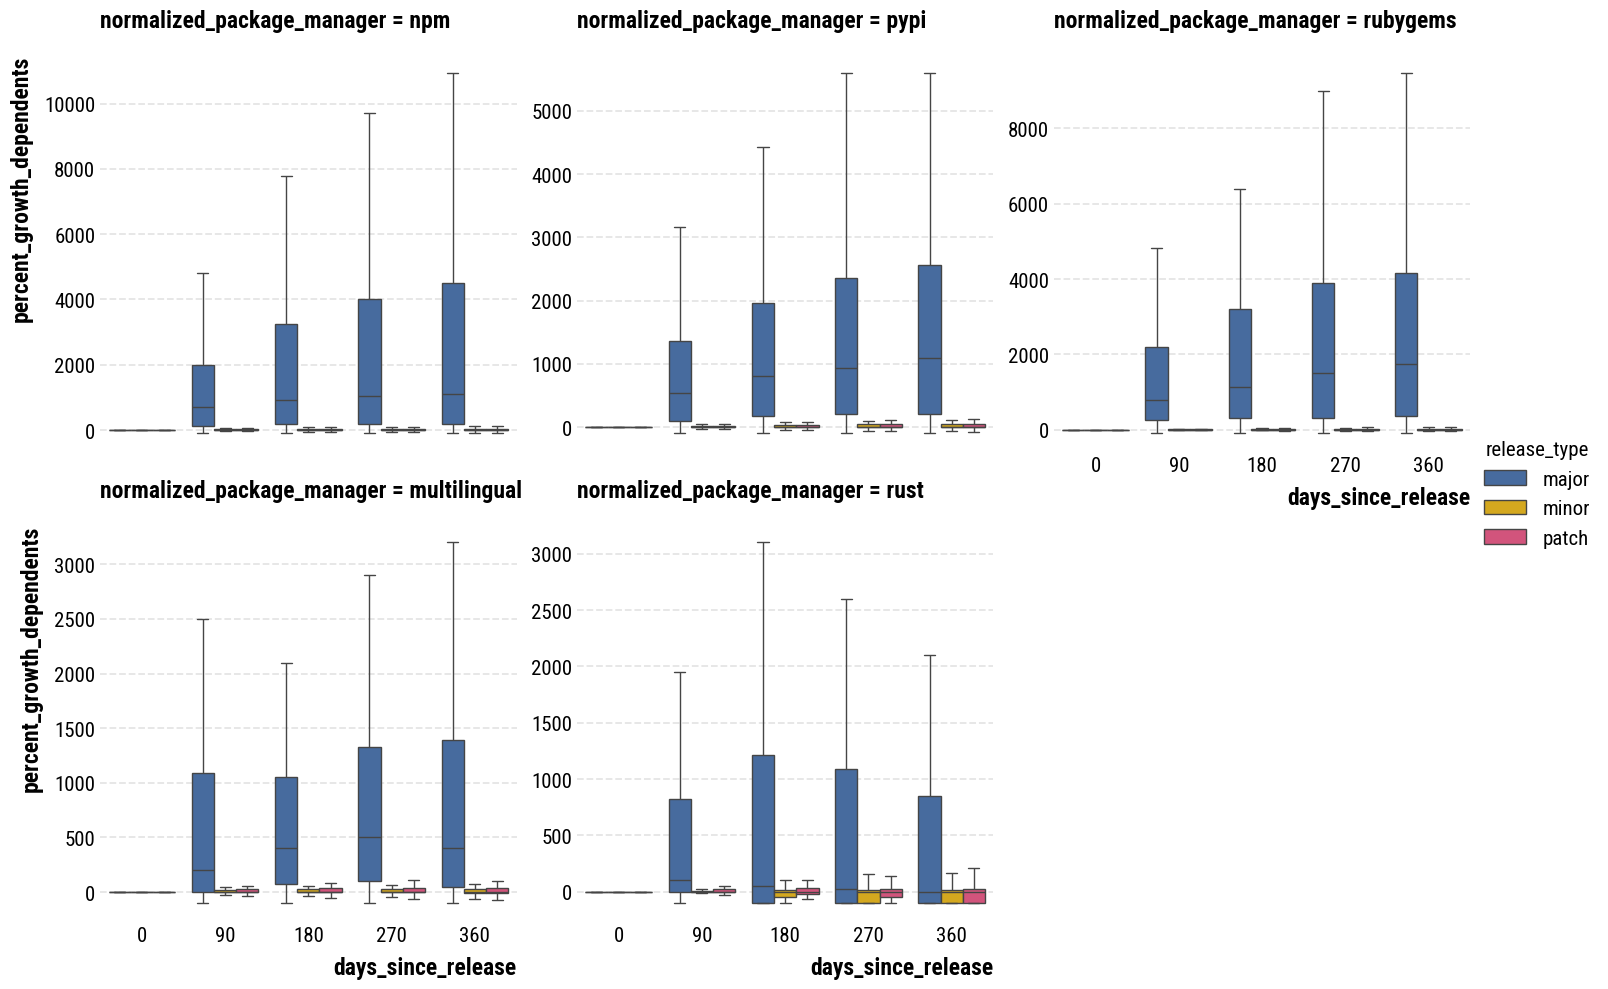

In [11]:
# Plot pct growth dependents
_ = sns.catplot(
    data=pct_growth_dependents_ecosystem_release_type.filter(
        pl.col("package_major_version").gt(pl.lit(1)),
    ),
    x="days_since_release",
    y="percent_growth_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    col="normalized_package_manager",
    col_wrap=3,
    showfliers=False,
    sharey=False,
)